In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import geopandas as gpd
import earthpy as et

import requests as rq

from header import AWhereAPI
from secret_codes import *

In [2]:
# Import codes from secret_codes.py
api_key = API_KEY
api_secret = API_SECRET

In [3]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

# General aWhere API endpoint "prefix"
endpt = "https://api.awhere.com"

In [4]:
# Create path to grid geojson
grid_path = os.path.join(et.io.HOME, "Desktop", "drought", "data", "created", "aoi_polys.geojson")

# Read as gdf
aoi_grid = gpd.read_file(grid_path)

# Add centroid column 
aoi_grid['centroid'] = aoi_grid.geometry.apply(lambda poly: poly.centroid)

# add ppet column with values of 0 
aoi_grid = aoi_grid.assign(ppet = 0)

In [5]:
# Pass in month and year
start_day = "2020-04-01"
end_day = "2020-04-30"

for index, row in aoi_grid.iterrows():
    
    # Get lat and long from grid
    latitude = row.centroid.y
    longitude = row.centroid.x
    
    # Get and parse json
    hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomicvalues/{start_day},{end_day}"
    
    # Endpoint suffix to get all accumulations
    ppet_append = "?properties=accumulations"
    
    # Get JSON
    ag_norms_period = rq.get((endpt + hist_ag_url + ppet_append), headers=agro_header).json()

    # Add accumulated ppet for April 2020
    aoi_grid.loc[index, 'ppet'] = ag_norms_period.get('accumulations').get('ppet')

In [14]:
# Better to save data as geojson. Does not support multiple
# geometry columns so we'll remove 'centroid'. Only need to
# run this cell if we haven't called the API in the above cell
#aoi_grid_export = aoi_grid.copy()

#aoi_grid_export.drop(columns=['centroid'], inplace=True)

# Create path to save aoi geojson
created_data_path = os.path.join(et.io.HOME, "desktop", 
                                 "drought", "data", "created")
# Go to path
os.chdir(created_data_path)

# Save aoi_grid as geojson if necessary
#aoi_grid_export.to_file("aoi_ppet_april_2020.geojson", driver='GeoJSON')

# Load AoI grid from geojson
#aoi_grid = gpd.read_file(aoi_grid_geojson_path)

In [16]:
# Create path to area of interest for plotting
aoi_path = os.path.join(et.io.HOME, "desktop", "drought", "data", "created", "aoi.shp")

# Create path to county boundaries for plotting
county_path = os.path.join(et.io.HOME, "desktop", "drought", "data", "TIGER", "cb_2018_us_county_500k.shp")

# Load all CA counties
counties = gpd.read_file(county_path)

# Select Siskyou county
siskiyou = counties[counties.NAME == 'Siskiyou']

# Load AoI into gdf
aoi = gpd.read_file(aoi_path)

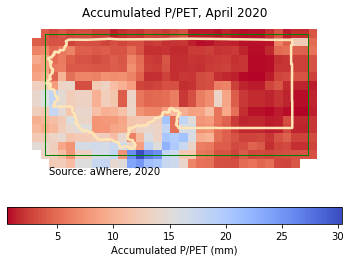

In [21]:
fig, ax = plt.subplots()

ax.set(title="Accumulated P/PET, April 2020")

aoi_grid.plot(column='ppet', ax=ax, cmap='coolwarm_r', legend=True,
             legend_kwds={'label': "Accumulated P/PET (mm)", 'orientation': "horizontal"})

aoi.plot(ax=ax, color="none", edgecolor="green")

siskiyou.plot(ax=ax, color="none", edgecolor="moccasin", linewidth=2.5)

ax.set_axis_off()

ax.text(0.1, 0.00001, transform=ax.transAxes, s="Source: aWhere, 2020")

plt.show()